In [1]:
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist
from Bio.PDB import *
import multiprocessing as mp
import h5py
import logging

In [2]:
# Biopython creates warnings for chains that are discontinuous. I recommend turning them off.
import warnings
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

In [3]:
logging.basicConfig(filename='data_generation.log',level=logging.ERROR)

In [4]:
# Requires absolute path
test_path = pathlib.Path("/home/collin/protein_gan/data/test/")
train_path = pathlib.Path("/home/collin/protein_gan/data/train/")

In [5]:
def generate_maps(files, res):
    """
    Generate specified resolution a-carbon maps given a input directory
    """
    matrix_list = []
    # Create A chain maps as matrices
    parser = PDBParser()
    io = PDBIO()
    try:
        # Get the initial structure of the protein
        structure = parser.get_structure('X', files)
        for models in structure:
            # Get the A-chain residues in each model
            for residue in models['A']:
                # Unfold residues to get all atoms starting at the first alpha carbon
                atom_list = Selection.unfold_entities(residue, 'A')[1:]
                # Create empty array to store temporary array coordinates
                arr_coord = []
                # Only selecting residues of a specified length
                if len(atom_list) >= res:
                    for atom in atom_list[0:res-1]:
                        x = atom.get_coord()
                        arr_coord.append({'X': x[0],'Y':x[1],'Z':x[2]})
                    coord_table = pd.DataFrame(arr_coord)
                    dist = pdist(coord_table, metric = 'euclidean')
                    distance_matrix = squareform(dist)
                    matrix_list.append(distance_matrix)
    except KeyError as err:
        logging.error(f'{files} raised KeyError: {err}')
    except ValueError as err:
        logging.error(f'{files} raised ValueError: {err}')
    except TypeError as err:
        logging.error(f'{files} rased TypeError: {err}') 
    return matrix_list


In [6]:
def clean_maps(files, res):
    """
    Clean the generated maps using all cores in the process
    """
    p = mp.Pool()
    formated_files = [(x, res) for x in files.iterdir()]
    r = list(p.starmap(generate_maps, formated_files))
    p.close()
    p.join()
    # Unwraveling the list generated by the map chunks
    n = [x for x in r if x]
    final_list = [item for sublist in n for item in sublist]
    return final_list

In [ ]:
with h5py.File("dataset.hdf5", "w") as f:
    # 16x16
    f.create_dataset("test_16", data=clean_maps(test_path, 16), compression="gzip")
    f.create_dataset("train_16", data=clean_maps(train_path, 16), compression="gzip")

    # 64x64
    f.create_dataset("test_64", data=clean_maps(test_path, 64), compression="gzip")
    f.create_dataset("train_64", data=clean_maps(train_path, 64), compression="gzip")

    # 128x128
    f.create_dataset("test_128", data=clean_maps(test_path, 128), compression="gzip")
    f.create_dataset("train_128", data=clean_maps(train_path, 128), compression="gzip")

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 463, in _handle_results
    task = get()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 411, in _recv_bytes
    return self._recv(size)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 386, in _recv
    buf.write(chunk)
MemoryError

Process ForkPoolWorker-27:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 125, in worker
    put((job, i, result))
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 341, in put
    obj = _ForkingPickler.dumps(obj)
  File "/usr/lib/python3.6/multiprocessing/r

In [14]:
f['test_128']

<HDF5 dataset "test_128": shape (0,), type "<f8">

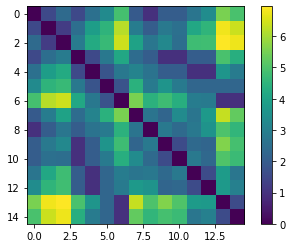

In [18]:
plt.imshow(final_list[1], cmap='viridis')
plt.colorbar()